In [1]:
import numpy as np
from scipy import stats, integrate
import pandas as pd
import matplotlib as mpl
import laplacejumps as lj
from matplotlib.dates import DateFormatter, AutoDateLocator, YearLocator
from matplotlib import patches, lines
from matplotlib.ticker import AutoLocator, MaxNLocator

In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')
presentation_fontsize=22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [27]:
np.linspace(0, 1, 12)

array([0.    , 0.0909, 0.1818, 0.2727, 0.3636, 0.4545, 0.5455, 0.6364,
       0.7273, 0.8182, 0.9091, 1.    ])

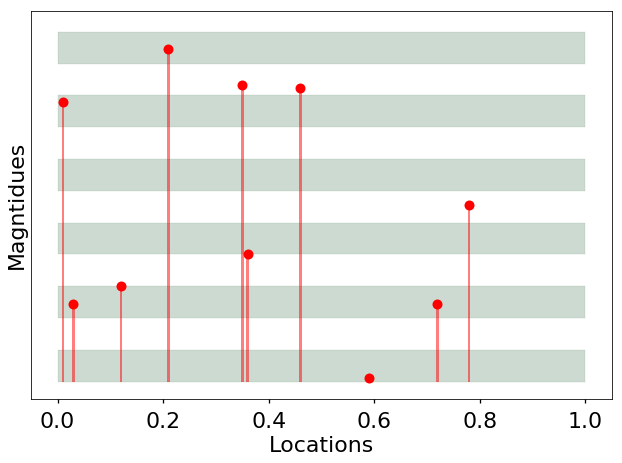

In [75]:
poisson_measure_fig, poisson_measure_ax = mpl.pyplot.subplots()
jump_dim = 10
heights = [0.79, 0.22, 0.27, 0.94, 0.84, 0.36, 0.83, 0.01, 0.22, 0.5]
locations = [ 0.01,  0.03,  0.12,  0.21,  0.35,  0.36, 0.46, 0.59,  0.72,  0.78]
poisson_measure_ax.bar(height=heights, x=locations, width=.005,  color='red', alpha=.5)
poisson_measure_ax.plot(locations, heights, marker='.', linestyle="", markersize=20, color='red')


bottoms = [0.  , 0.18, 0.36, 0.54, 0.72, 0.90]

for bottom in bottoms:
    poisson_measure_ax.fill_between(x=[0,1], y1=bottom, y2=bottom+.09, color='#014A19', alpha=.2)
    
poisson_measure_ax.set_xlim([-.05,1.05])
poisson_measure_ax.set_ylim([-.05,1.05])
poisson_measure_ax.set_ylabel('Magntidues')
poisson_measure_ax.set_yticks([])
poisson_measure_ax.set_xlabel('Locations')
poisson_measure_fig.savefig('../doc/figures/poisson_random_measure.pdf', bbox_tight=True,
                            transparent=True, pad_inches=0, frameon=False)

In [76]:
def sum_pdf(x):
    return (stats.laplace.pdf(x, scale=2**(-.5)) + stats.norm.pdf(x, scale=1)) / 2

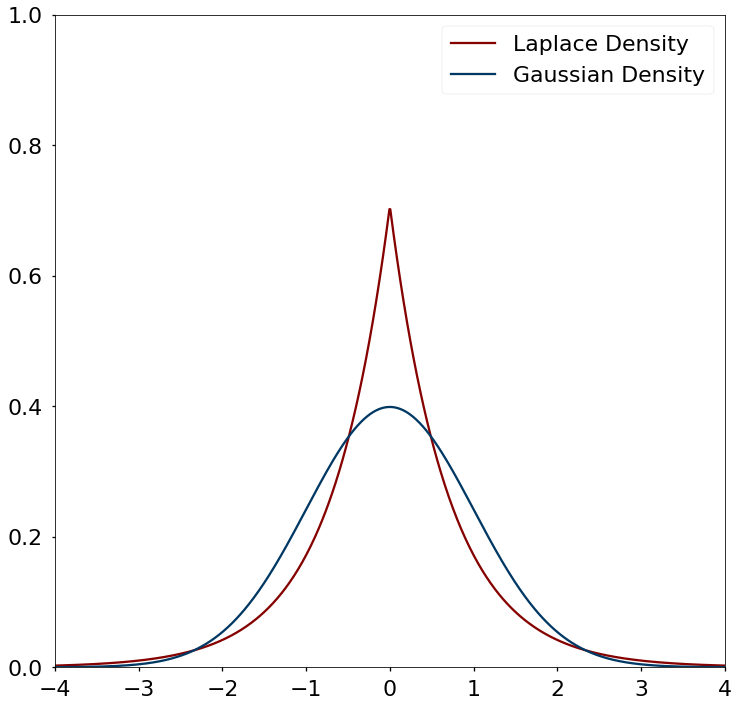

In [107]:
xvals1 = np.linspace(-5, 5, 1000)
joint_plot_fig, joint_plot_ax = mpl.pyplot.subplots()
joint_plot_fig.set_size_inches((12,12))
joint_plot_ax.plot(xvals1, [stats.laplace.pdf(x, scale=2**(-.5)) for x in xvals1], label='Laplace Density', 
                  color='#850100')
joint_plot_ax.plot(xvals1, [stats.norm.pdf(x, scale=1) for x in xvals1], label='Gaussian Density',
                   color='#003864')
joint_plot_ax.set_xlim([-4, 4])
joint_plot_ax.set_ylim([0,1])
joint_plot_ax.legend()
joint_plot_fig.savefig('../doc/figures/density_comparison.pdf', bbox_tight=True, transparent=True,
                      pad_inches=0, frameon=False)

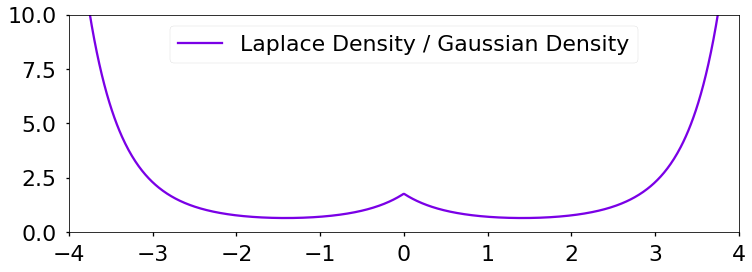

In [106]:
xvals2 = np.linspace(-5, 5, 1000)
ratio_fig, ratio_ax = mpl.pyplot.subplots()
ratio_fig.set_size_inches((12,4))
ratio_ax.plot(xvals2,  [stats.laplace.pdf(x, scale=2**(-.5)) / stats.norm.pdf(x) for x in xvals2], 
             label='Laplace Density / Gaussian Density', color='#7A00E6')
ratio_ax.set_xlim([-4, 4])
ratio_ax.set_ylim([0,10])
ratio_ax.legend()
ratio_fig.savefig('../doc/figures/density_ratio.pdf', bbox_tight=True, transparent=True, pad_inches=0,
                  framon=False)

In [ ]:
spy = pd.read_hdf('../data/spy_2010-2012_300ms.hdf', 'table')

In [ ]:
spy.resample('D').last().count()

In [ ]:
data_fig, data_ax = mpl.pyplot.subplots()
data_ax.plot(spy.resample('5min').last().apply(np.exp).dropna())
data_ax.xaxis.set_major_formatter( DateFormatter('%B \'%y'))
data_ax.xaxis.set_major_locator(AutoDateLocator(maxticks=6))
data_ax.set_ylabel("Price")
data_fig.savefig('../doc/figures/spy.tmp.pdf', bbox_inches='tight', frameon=False, transparent=True)

In [ ]:
date = '2012-04-16'
frequency = '1s'
num_std_devs = 4
omega = .49
day_1_root_vol = np.sqrt(lj.bipower(spy[date].apply(np.log).resample('5min').last().diff().dropna()))
threshold = num_std_devs * day_1_root_vol * spy[date].resample(frequency).last().count()**(-omega)

In [ ]:
fig_lopez_threshold = np.sqrt(3 * day_1_root_vol**2 * np.log(spy[date].resample(frequency).last().count()) 
                              / spy[date].resample(frequency).last().count())

In [ ]:
log_price_data = pd.DataFrame(spy[date].resample(frequency).last().apply(np.log).diff())
jump_data = log_price_data.abs().query('log_price > @threshold')
merged_data = pd.concat([jump_data.rename(columns={'log_price':'jumps'}), log_price_data], axis=1)
jump_locations = np.where(merged_data.iloc[:,0].notnull())[0]
diffusion_locations = np.where(merged_data.iloc[:,0].isnull())[0]

In [ ]:
jump_data.head()

In [ ]:
discrete_rtn = spy.resample('D').last()['2012'].apply(np.log).diff().dropna()
cont_rtn = spy[date].resample('1s').last().apply(np.log).diff()

In [ ]:
log_rtn_fig, (cont_log_price_ax, daily_log_rtn_ax) = mpl.pyplot.subplots(ncols=2, figsize=(14,6))
daily_log_rtn_ax.plot(discrete_rtn, color=colors['price'])
cont_log_price_ax.plot(merged_data.iloc[diffusion_locations].index,
                       merged_data['log_price'].iloc[diffusion_locations], zorder=10, color=colors['diffusion'])
cont_log_price_ax.bar(merged_data.iloc[jump_locations].index, merged_data['log_price'].iloc[jump_locations], 
                      color=colors['jumps'], width=.0025, zorder=0)
cont_log_price_ax.set_xlim(merged_data.index[0] + pd.Timedelta('9 hours'),
                           merged_data.index[0] + pd.Timedelta('16.5 hours'))
cont_log_price_ax.set_ylim([-0.0006, 0.0006])
daily_log_rtn_ax.set_ylim([-0.006, 0.006])

time_fraction = (pd.to_datetime(date) - discrete_rtn.index[0]) / (discrete_rtn.index[-1] - discrete_rtn.index[0])
dim = .025
rect = patches.Rectangle(xy=(time_fraction - dim/2,.5 - dim/2), width=dim, height=dim, fill=False, edgecolor='black', 
                         linewidth=2, zorder=2, transform=daily_log_rtn_ax.transAxes)

cont_log_price_ax.set_xlabel("")
daily_log_rtn_ax.add_artist(rect)
cont_log_price_ax.tick_params(top=None, right=None)
cont_log_price_ax.ticklabel_format(axis='y', useOffset=False)
cont_log_price_ax.xaxis.set_major_locator(AutoDateLocator(maxticks=4))
daily_log_rtn_ax.xaxis.set_major_locator(AutoDateLocator(maxticks=4))
cont_log_price_ax.xaxis.set_major_formatter(DateFormatter('%b %-d, %-I:%M'))
daily_log_rtn_ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
daily_log_rtn_ax.yaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
cont_log_price_ax.yaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
log_rtn_fig.tight_layout(h_pad=0)

transFigure = log_rtn_fig.transFigure.inverted()
coord11 = transFigure.transform(cont_log_price_ax.transAxes.transform([1,1]))
coord12 = transFigure.transform(daily_log_rtn_ax.transAxes.transform([time_fraction - dim/2,.5 +  dim/2]))
coord21 = transFigure.transform(cont_log_price_ax.transAxes.transform([1,0]))
coord22 = transFigure.transform(daily_log_rtn_ax.transAxes.transform([time_fraction - dim/2,.5 - dim/2]))

line1 = lines.Line2D(xdata=(coord11[0], coord12[0]), ydata=(coord11[1], coord12[1]),color='black',
                     transform=log_rtn_fig.transFigure, linestyle='dashed', linewidth=1.5)
line2 = lines.Line2D(xdata=(coord21[0], coord22[0]), ydata=(coord21[1], coord22[1]),color='black',
                     transform=log_rtn_fig.transFigure, linestyle='dashed', linewidth=1.5)
log_rtn_fig.lines = [line1, line2]


log_rtn_fig.savefig('../doc/figures/spy_log_rtn.tmp.pdf', bbox_inches='tight', frameon=False, transparent=True)


In [ ]:
real_vol = pd.DataFrame(spy.apply(np.log).diff().groupby(pd.TimeGrouper('D')).apply(lambda x: np.sqrt(np.sum(x**2))))

In [ ]:
real_vol.head()

In [ ]:
cont_time_dgp_fig = mpl.pyplot.figure()
cont_time_dgp_fig.set_size_inches(5, 1.5)
cont_time_dgp_ax = mpl.pyplot.Axes(cont_time_dgp_fig, [0., 0., 1., 1.])
cont_time_dgp_ax.set_axis_off()
cont_time_dgp_fig.add_axes(cont_time_dgp_ax)
text_string1 =  r"""\[\mathop{}\!d p(t) = """
text_string2 =  r"""\sigma(t)  \mathop{}\!d W(t) """
text_string3 =  r""" + \int_{\mathcal{X}} \delta(t, x) (\mu - \nu)(\mathop{}\!dt, \mathop{}\!dx)\]"""
cont_time_dgp_ax.text(s=text_string1 + text_string2 + text_string3, y=.4, x=.43, fontsize=16, 
                      verticalalignment='center', transform=cont_time_dgp_ax.transAxes, 
                      horizontalalignment='center', color='blue')
cont_time_dgp_ax.annotate('Diffusion Volatility', xy=(.16, .48), xytext=(.01, .8), horizontalalignment='center',
                          arrowprops=dict(facecolor='black', width=1, headwidth=5), verticalalignment='center',
                          xycoords='axes fraction', textcoords='axes fraction')
cont_time_dgp_ax.annotate('Wiener Process', xy=(.28, .52), xytext=(.28, .95), horizontalalignment='center',
                          arrowprops=dict(facecolor='black', width=1, headwidth=5), verticalalignment='center',
                          xycoords='axes fraction', textcoords='axes fraction')
cont_time_dgp_ax.annotate('Jump Magnitude Function', xy=(.5, .52), xytext=(.68, .8), 
                          horizontalalignment='center', arrowprops=dict(facecolor='black', width=1, headwidth=5), 
                          verticalalignment='center', xycoords='axes fraction', textcoords='axes fraction')
cont_time_dgp_ax.annotate('Demeaned Jump Locations', xy=(.67, .48), xytext=(.87, .68), 
                          horizontalalignment='center', verticalalignment='center',
                          arrowprops=dict(facecolor='black', width=1, headwidth=5), 
                          xycoords='axes fraction', textcoords='axes fraction')
cont_time_dgp_ax.annotate(r'\underbrace{\phantom{\sigma(t)  \mathop{}\!d W(t)\ }}_{'
                          r'\text{Diffusion Part}\ (dp^D)\ \ }', 
                          xy=(.24, .4), xytext=(.24, .23), horizontalalignment='center',
                          verticalalignment='center', xycoords='axes fraction', textcoords='axes fraction', 
                          fontsize=16)
cont_time_dgp_ax.annotate(r' \underbrace{\phantom{\int_{\mathcal{X}} \delta(t, x) ' 
                          + r'(\mu - \nu)(\mathop{}\!dt, \mathop{}\!dx)}}_{\text{Jumps}\ (d p^J)\ \ }', 
                          xy=(.64, .35), xytext=(.64, .1), horizontalalignment='center',verticalalignment='center', 
                          xycoords='axes fraction', textcoords='axes fraction', fontsize=16)
cont_time_dgp_fig.savefig('../doc/figures/dgp.tmp.pdf', bbox_inches='tight', frameon=False, transparent=True)

In [ ]:
mdh_fig = mpl.pyplot.figure()
mdh_fig.set_size_inches(5, 1.5)
mdh_ax = mpl.pyplot.Axes(mdh_fig, [0., 0., 1., 1.])
mdh_ax.set_axis_off()
mdh_fig.add_axes(mdh_ax)
text_str1 = r'\[r_t \vert \mathcal{F}_{t-1} \sim h(r_t \vert \mathcal{F}_{t-1}) ' 
text_str2 = r'= \int_{x_t} f(r_t \vert x_t) \mathop{}\!d G(x_t | \mathcal{F}_{t-1}) \]'
text_str = text_str1 + text_str2
mdh_ax.text(s=text_str, y=.5, x=.5, fontsize=16, transform=mdh_ax.transAxes, horizontalalignment='center', 
            color='blue', verticalalignment='center', )
mdh_ax.annotate('Sufficient Statistic for the Dynamics', xy=(.56, .36), xytext=(.88, .20), 
                horizontalalignment='center',arrowprops=dict(facecolor='black', width=1, headwidth=5), 
                verticalalignment='center',xycoords='axes fraction', textcoords='axes fraction')
mdh_fig.savefig('../doc/figures/mdh.tmp.pdf', bbox_inches='tight', frameon=False, transparent=True)

In [ ]:
real_dens_fig = mpl.pyplot.figure()
real_dens_fig.set_size_inches(5, 1.5)
real_dens_ax = mpl.pyplot.Axes(real_dens_fig, [0., 0., 1., 1.])
real_dens_ax.set_axis_off()
real_dens_fig.add_axes(real_dens_ax)
text_str1 = r"""\[RD_t = \mathcal{N}\left(0, \int_{t-1}^t \sigma^2(s) \mathop{}\!d s \right) """
text_str2 = r"""\ast \mathcal{L}\left(0,\int_{t-1}^t \gamma^2(s) \mathop{}\!d s \right)\]"""
real_dens_ax.text(s=text_str1 + text_str2, y=.5, x=.5, fontsize=16, transform=real_dens_ax.transAxes, 
                  horizontalalignment='center', color='black', verticalalignment='center')
real_dens_ax.annotate('Convolution', xy=(.57, .61), xytext=(.57, .9), horizontalalignment='center',
                          arrowprops=dict(facecolor='black', width=1, headwidth=5), verticalalignment='center',
                          xycoords='axes fraction', textcoords='axes fraction')
real_dens_ax.annotate('Laplace Distribution', xy=(.59, .42), xytext=(.42, .15), horizontalalignment='center',
                          arrowprops=dict(facecolor='black', width=1, headwidth=5), verticalalignment='center',
                          xycoords='axes fraction', textcoords='axes fraction')
real_dens_fig.savefig('../doc/figures/real_dens_conv.tmp.pdf', bbox_inches='tight', frameon=False, transparent=True)
            
            